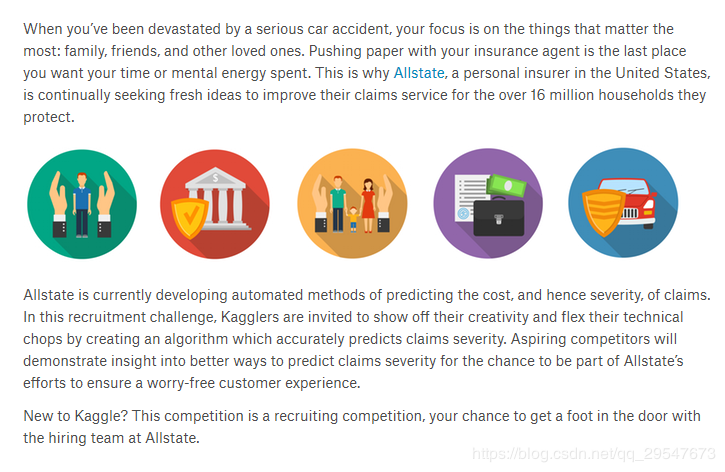

In [1]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import KFold,train_test_split

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'


## 数据预处理

In [2]:
train = pd.read_csv('allstate-claims-severity/train.csv')

In [1]:
train['log_loss']=np.log(train['loss'])

NameError: name 'np' is not defined

In [4]:
features = [x for x in train.columns if x not in ['id','loss','log_loss']]

cat_features =[x for x in train.select_dtypes(include = ['object']) if x not in ['id','loss','log_loss']]

num_features =[x for x in train.select_dtypes(exclude = ['object']) if x not in ['id','loss','log_loss']]           

print('离散特征Categorical: {} features'.format(len(cat_features)))
print('Numerical:{} features'.format(len(num_features)))
features

离散特征Categorical: 116 features
Numerical:14 features


['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18',
 'cat19',
 'cat20',
 'cat21',
 'cat22',
 'cat23',
 'cat24',
 'cat25',
 'cat26',
 'cat27',
 'cat28',
 'cat29',
 'cat30',
 'cat31',
 'cat32',
 'cat33',
 'cat34',
 'cat35',
 'cat36',
 'cat37',
 'cat38',
 'cat39',
 'cat40',
 'cat41',
 'cat42',
 'cat43',
 'cat44',
 'cat45',
 'cat46',
 'cat47',
 'cat48',
 'cat49',
 'cat50',
 'cat51',
 'cat52',
 'cat53',
 'cat54',
 'cat55',
 'cat56',
 'cat57',
 'cat58',
 'cat59',
 'cat60',
 'cat61',
 'cat62',
 'cat63',
 'cat64',
 'cat65',
 'cat66',
 'cat67',
 'cat68',
 'cat69',
 'cat70',
 'cat71',
 'cat72',
 'cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101

In [5]:
ntrain = train.shape[0]
#ntrain = 188318

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
print('Xtrain:',train_x.shape)
print('ytrain:',train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


In [6]:
train_x

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0,1,0,0,0,0,0,0,1,0,...,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216
188314,0,0,0,0,0,1,0,0,0,0,...,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872
188315,0,1,0,0,0,0,0,1,1,0,...,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888
188316,0,1,0,0,0,0,0,0,1,1,...,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707


## Simple XGBoost Model
    首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差衡量mean_absolute_error(np.exp(y),np.exp(yhat))
    xgboost自定义一个数据矩阵类DMatrix，会在训练开始时，进行一边预处理，从而提高之后每次迭代的效率
### 结果衡量方法

In [7]:
#评估策略，e的次幂，用来评估。
#结果衡量方法：使用平均绝对误差来衡量
#mean_absolute_error(np.exp(y), np.exp(yhat))。
#定义计算损失值的函数
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

### Model

In [8]:
#数据类型转换成库可以使用的底层格式。
dtrain = xgb.DMatrix(train_x,train['log_loss'])
dtrain

# Xgboost参数  
         
    ·'booster':'gbtree',梯度提升树
    ·'objective': 'multi:softmax', 多分类的问题  
    ·'num_class':10, 类别数，与 multisoftmax 并用
    ·'gamma':损失下降多少才进行分裂
    ·'max_depth':12, 构建树的深度，越大越容易过拟合
    ·'lambda':2, 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    ·'subsample':0.7, 随机采样训练样本 // 取70%的数据训练
    ·'colsample_bytree':0.7, 生成树时进行的列采样
    ·'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
    ·'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
    ·'eta': 0.007, 如同学习率。//后加树 的贡献率
    ·'seed':1000,
    ·'nthread':7, cpu 线程数
————————————————  
版权声明：本文为CSDN博主「好瘦的小胖子」的原创文章，遵循 CC 4.0 BY-SA 版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/qq_29547673/article/details/89319061

In [9]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 xgb.cv

In [10]:
%%time

#feval:评估策略
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1220.110026
Wall time: 1min 3s


<Figure size 432x288 with 0 Axes>

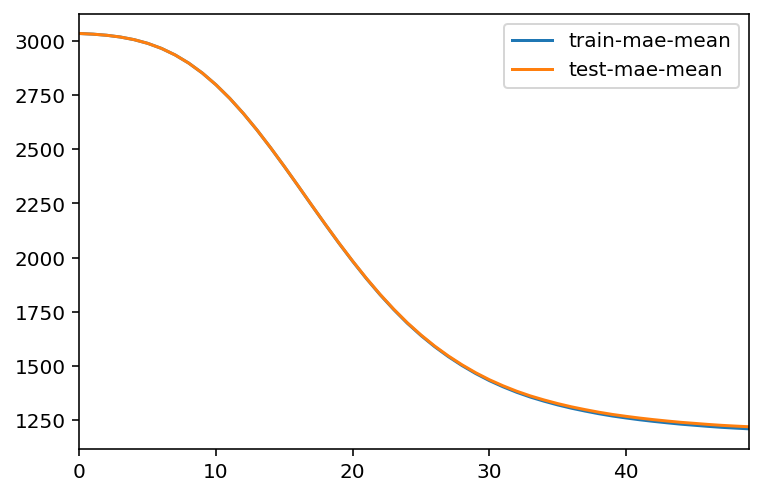

In [11]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot() 

## 上面是我们第一个模型
    ·没有发生过拟合  
    ·只建立了50个树模型

## XGBoost 参数调节
    Step 1: 选择一组初始参数
    Step 2: 改变 max_depth 和 min_child_weight.
    Step 3: 调节 gamma 降低模型过拟合风险.
    Step 4: 调节 subsample 和 colsample_bytree 改变数据采样策略.
    Step 5: 调节学习率 eta.  
    
经过xgboost的调参策略。得到更好的参数：  
XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07).

In [15]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})#默认参数
        
    def fit(self, x_train, y_train):
        '''
        #数据类型转换,#用参数去训练xgboost模型
        '''
        dtrain = xgb.DMatrix(x_train, y_train) 
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self 


In [16]:
#衡量标准
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [17]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)



In [18]:
bst.kfold(train_x, train_y, nfold=5)

train-rmse-mean       0.558938
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-mae-mean     1209.707324
train-mae-std         3.004207
test-mae-mean      1218.884204
test-mae-std          8.982969
Name: 49, dtype: float64

### 按照训练集处理方式，处理我们的测试集

In [19]:
test = pd.read_csv('allstate-claims-severity/test.csv')

test#没有loss列,loss需要预测

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,A,A,A,B,A,A,A,A,A,...,0.281143,0.438917,0.815941,0.39455,0.48740,0.40666,0.550529,0.538473,0.298734,0.345946
125542,587621,A,A,A,A,B,B,A,B,A,...,0.674529,0.346948,0.424968,0.47669,0.25753,0.26894,0.324486,0.352251,0.490001,0.290576
125543,587627,B,B,A,A,B,A,A,A,B,...,0.794794,0.808958,0.511502,0.72299,0.94438,0.83510,0.933174,0.926619,0.848129,0.808125
125544,587629,A,A,A,A,A,B,A,B,A,...,0.302678,0.372125,0.388545,0.31796,0.32128,0.36974,0.307628,0.301921,0.608259,0.361542


In [20]:
#features_test = [x for x in test.columns if x not in ['id']]

test_x = test[features]

#将类别数据的类别用数字替换
for c in range(len(cat_features)):

    test_x[cat_features[c]] = test_x[cat_features[c]].astype('category').cat.codes

test_x.head()


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,0,0,0,0,0,1,0,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,0,1,0,1,0,0,0,0,1,0,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,0,1,0,1,1,0,1,0,1,1,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,0,0,0,0,1,0,0,0,0,0,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,1,0,0,0,0,1,0,0,0,0,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


### 数据预测

In [21]:
#数据类型转换成库可以使用的底层格式。
#dtest_x = xgb.DMatrix(test_x)
#dtest_x
#得到我们想要的测试集


#预测命令：

test_y = bst.predict(test_x)

In [22]:
test_y[1],len(test_y)

(7.450635, 125546)

In [35]:
import math

#math.exp(test_y[0])
def test_exp_y_predict(test_y):
    '''
    取log()的反函数
    '''
    test_exp_y= np.zeros(len(test_y))
    for i in range(len(test_y)):
        test_exp_y[i] = math.exp(test_y[i])
    return test_exp_y

pre_y = test_exp_y_predict(test_y)
pre_y.shape

(125546,)

## 下面使用经过调参优化后的xgboost模型，进行预测分析

In [36]:
best_model = XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07)

In [38]:
%%time

best_model.kfold(train_x, train_y, nfold=5)

Wall time: 6min 3s


train-rmse-mean       0.496316
train-rmse-std        0.000353
test-rmse-mean        0.537659
test-rmse-std         0.002246
train-mae-mean     1041.517920
train-mae-std         1.356585
test-mae-mean      1145.610254
test-mae-std          8.666762
Name: 199, dtype: float64

In [2]:
def output_predict(test_pre):
    '''
    处理模型的预测值。
    过程：取log()的反函数,输出list格式、保留两位小数的预测值
    input:模型直接输出的预测值
    output:经过还原的预测值test_pre_y
    '''
    
    #取log()的反函数
    test_pre_array= np.zeros(len(test_pre))
    for i in range(len(test_pre)):
        test_pre_array[i] = math.exp(test_pre[i])
    print('test_exp_y.shape:',test_pre_array.shape)
    #数组array 转 列表list 格式
    test_pre_list = test_pre_array.tolist()
    #保留两位小数
    test_pre_list = np.around(test_pre_list, decimals=2)
    
    return test_pre_list


def plt_id_loss(test):
    plt.figure(figsize=(16,8))
    plt.plot(test['id'],test['loss'])
    print('test[\'id\']个数:',len(test['id']))
    plt.title('Loss values per id')
    plt.xlabel('id')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return '数据集id 与 loss 图像绘制成功！'

In [39]:
test_pre = best_model.predict(test_x)

In [40]:
test_pre_array=test_exp_y_predict(test_pre)
print('test_pre.shape:',test_pre_array.shape)
test_pre_array

test_pre.shape: (125546,)


array([1553.88363867, 1674.73612157, 9128.16204738, ..., 2369.43253642,
       1044.38334379, 3081.44380484])

上面是我们用xgboost模型预测的test数据集的loss。我们画图来看看预测结果。

In [41]:

#数组array 转 列表list 格式
test_pre_list = test_pre_array.tolist()

#保留两位小数
test_pre_list = np.around(test_pre_list, decimals=2)

test['loss'] = test_pre_list
test

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,1553.88
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,1674.74
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,9128.16
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,5581.20
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,780.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,A,A,A,B,A,A,A,A,A,...,0.438917,0.815941,0.39455,0.48740,0.40666,0.550529,0.538473,0.298734,0.345946,2027.97
125542,587621,A,A,A,A,B,B,A,B,A,...,0.346948,0.424968,0.47669,0.25753,0.26894,0.324486,0.352251,0.490001,0.290576,1973.99
125543,587627,B,B,A,A,B,A,A,A,B,...,0.808958,0.511502,0.72299,0.94438,0.83510,0.933174,0.926619,0.848129,0.808125,2369.43
125544,587629,A,A,A,A,A,B,A,B,A,...,0.372125,0.388545,0.31796,0.32128,0.36974,0.307628,0.301921,0.608259,0.361542,1044.38


No handles with labels found to put in legend.


test['id']个数: 125546


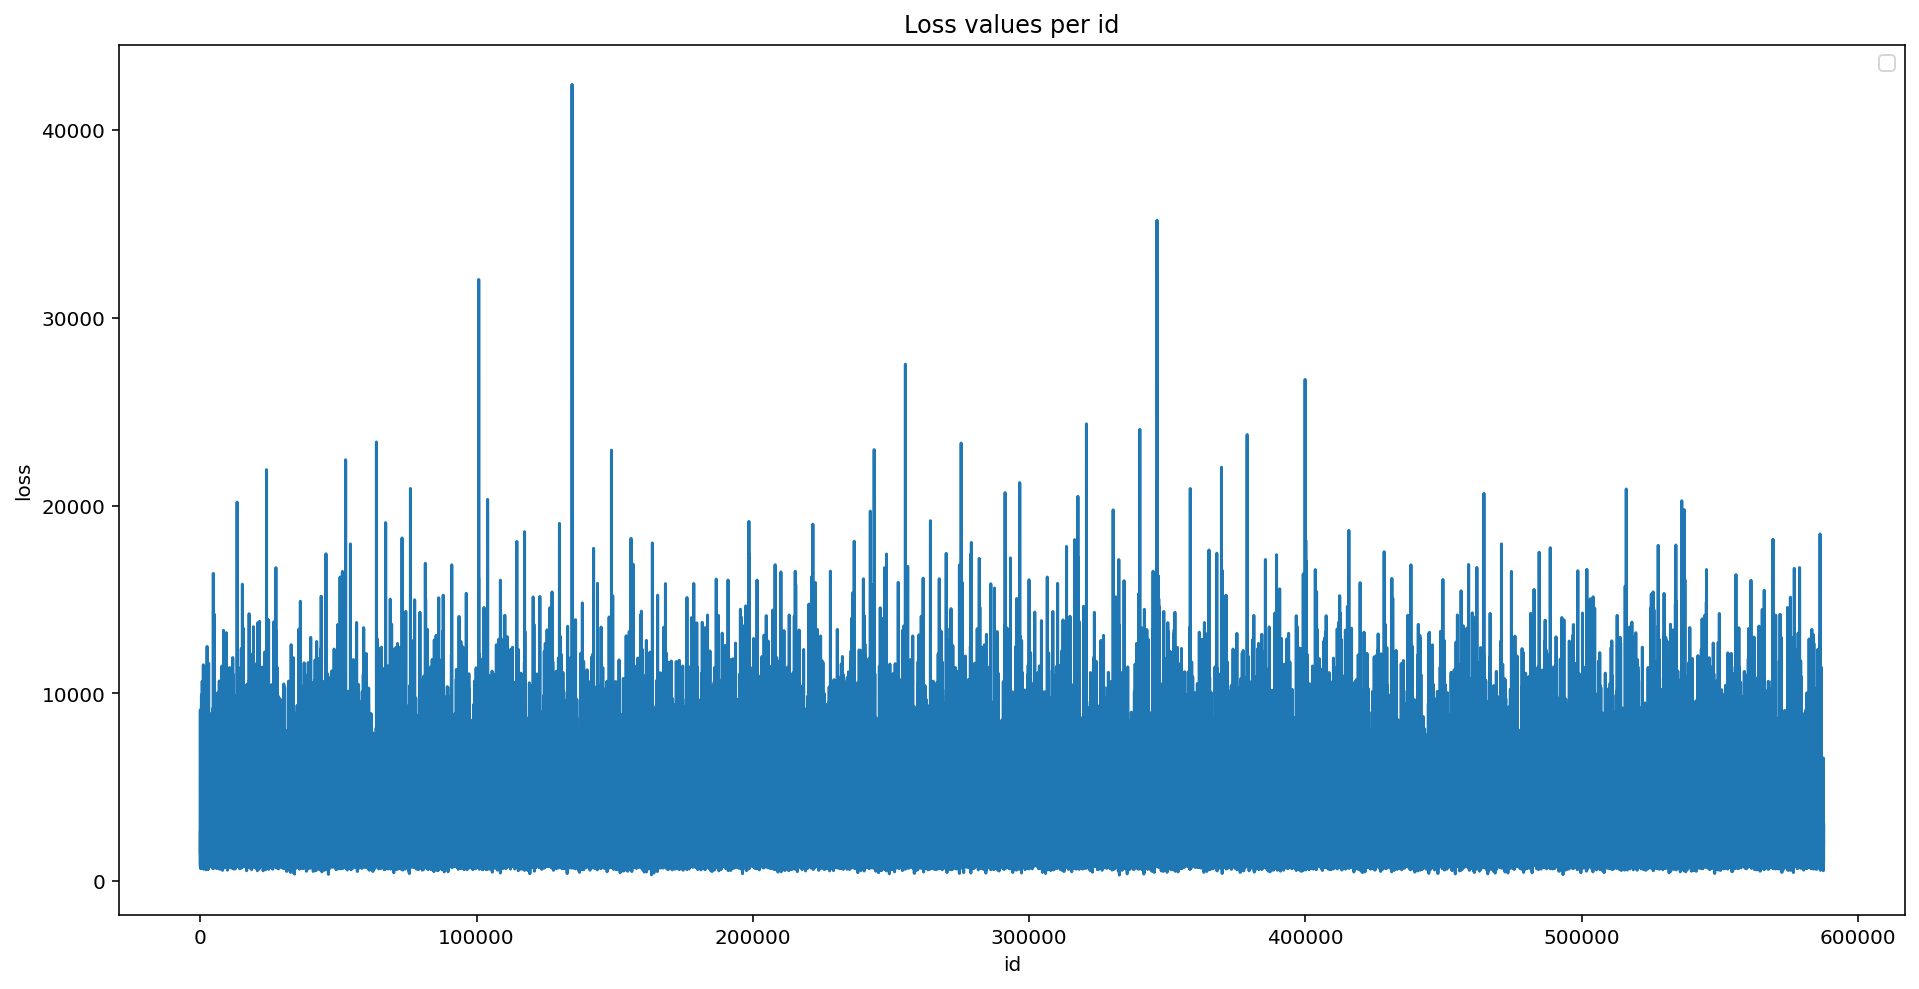

In [42]:
plt.figure(figsize=(16,8))
plt.plot(test['id'],test['loss'])
print('test[\'id\']个数:',len(test['id']))
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()